### 何でふたつのファイルがある？
see_resultsとsatohara_resultsの違いは？？毎回ちゃんとnotebookにメモしろ。覚えてられる訳が無い。セルで取り組んでる内容も説明しろ。

In [1]:
import sys
import os
from itertools import product
from pathlib import Path
sys.path.append(
    os.path.dirname(os.path.abspath('.'))
)
from src import QNet, Agent, agent_metrics, show_reward, settings
### path load

import japanize_matplotlib
from skimage import restoration
from scipy.signal import fftconvolve
import numpy as np
import torch
from torchvision import datasets
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
from blur_funcs import kernel1 as k1,kernel2 as k2,FUNCS_GR, ACTIONS_GR, ACTIONS_GR2, FUNCS_RN, ACTIONS_RN, ACTIONS_WO_RN_BLUR

SEED = 0
device = 'cuda:0'

### 作業1
先生の環境で学習したQnet020000.pthのモデルを、手元のコードで評価した結果が、先生の手元の評価値と異なるかを確認する。 

先生の環境でのMSE
* (gauss x3) 初期画像[0.042], gauss wiener x3[0.014], agent[0.014]  
* (random x3)初期画像[0.046], random wiener x3[0.020], agent[0.022]

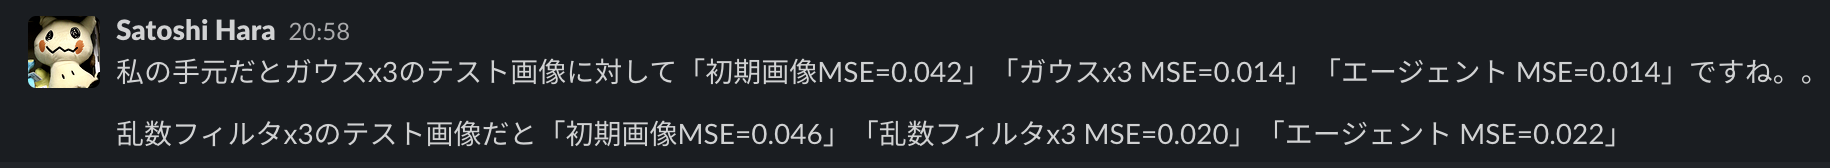
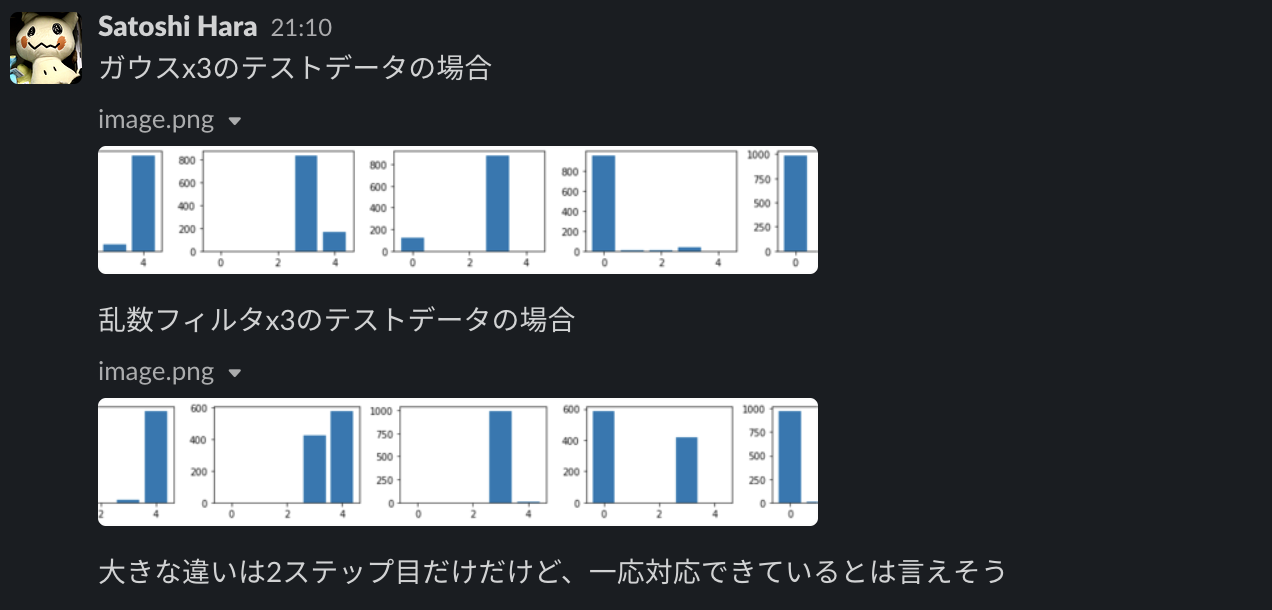

gaussとrandomの2パターンで試す。

In [2]:
# Qnetでの性能を測定
std = 3.0
f = np.vectorize(lambda x, y: multivariate_normal([0.0, 0.0], np.diag([std]*2)).pdf([x, y]))
X, Y = np.meshgrid(np.arange(-2, 3, 1, dtype=np.float32), np.arange(-2, 3, 1, dtype=np.float32))
kernel1 = f(X, Y)
kernel1 = kernel1 / kernel1.sum()
np.random.seed(0)
kernel2 = np.random.rand(*kernel1.shape)
kernel2 = kernel2 / kernel2.sum()
filt = []
filt.append(lambda x: x)
filt.append(lambda x: np.maximum(0, fftconvolve(x, kernel1, mode='same')))
filt.append(lambda x: np.maximum(0, fftconvolve(x, kernel2, mode='same')))
filt.append(lambda x: np.maximum(0, restoration.wiener(x, kernel1, 1e-2)))
filt.append(lambda x: np.maximum(0, restoration.wiener(x, kernel2, 1e-2)))
channel = 2

seed = 0
# データの読み込み

In [6]:
def check_mse(model_path):
    '''model_pathを指定したら、gauss, randomのc3のデータセットでのMSEを評価する'''
    Qnet = QNet(c=channel, m=[20, 20, len(filt)])
    Qnet.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    for filt_type in ['gauss', 'random']:
        print(filt_type, flush=True)
        context = np.load(
            os.path.join('data/GR3.0/test', filt_type, f'c3_dataset.npz')
        )
        Dy = torch.from_numpy(context['test_dataset'])
        Dx = torch.from_numpy(context['original_dataset'])

        result = agent_metrics(Dy, Dx, Qnet, filt, channel=channel)
        print(f'mse = {result[:, -1].mean()}+-{result[:, -1].std()}')

        fig, axes = plt.subplots(1, 5, figsize=(15, 2))
        for j in range(5):
            axes[j].hist(result[:, j], bins=np.arange(6) - 0.5, density=True)
        plt.tight_layout()
        plt.show()
        print()

### 先生のコードで学習したと想定しているモデルのMSEを測定した結果

gauss


100%|██████████| 10000/10000 [00:47<00:00, 212.58it/s]


mse = 0.014110839128517546+-0.004965846967541105


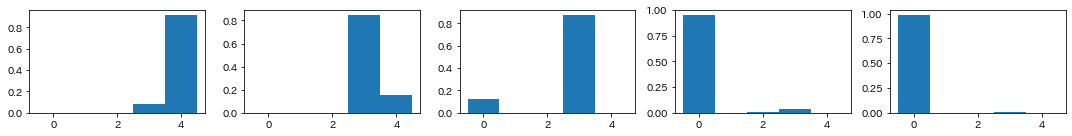


random


100%|██████████| 10000/10000 [00:50<00:00, 196.61it/s]


mse = 0.021505096565838905+-0.00825363370084882


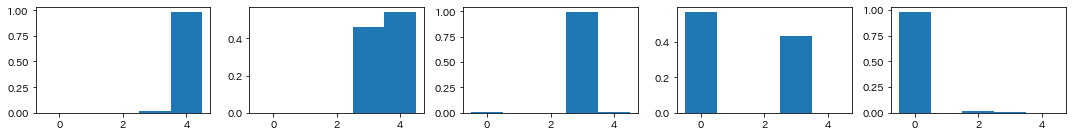

In [7]:
check_mse('./results/Qnet020000.pth')

### 手元のコードで学習したと想定しているモデルのMSEを測定した結果
* しかし、結果が先生の手元と一致してしまった。というかむしろ手元の方が良い？
* とりあえず、GR3.0のデータセットを使って学習し直してみよう。

gauss


100%|██████████| 10000/10000 [00:30<00:00, 332.39it/s]


mse = 0.013464098260295577+-0.005146324812387937


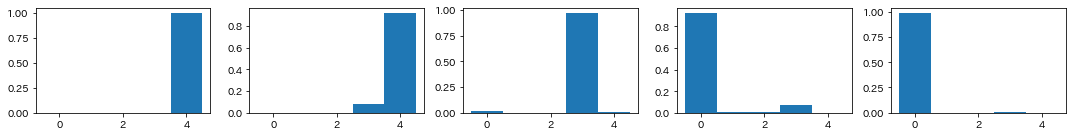


random


100%|██████████| 10000/10000 [00:42<00:00, 237.31it/s]


mse = 0.02031868039141409+-0.009784640793967106


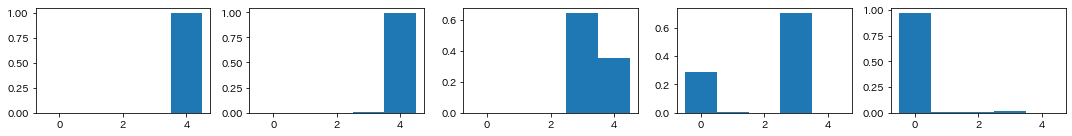

In [9]:
check_mse('./results/GR3.0_2/channel02_weight005_seed00/Qnet020000.pth')

In [10]:
labels = ['gauss', 'random', 'smooth']
actions = [lambda x: x] + ACTIONS_GR
# 結果の対象パスどこ
# setting3, setting4
seed = 0
RESULT_PATH = ''
# 3種類のフィルタ
for l in range(3):
    # 回数を1~5
    for c in range(1, 6):
        # データの読み込み
        context = np.load(
            os.path.join('data/GR3.0/test', labels[l], f'c{c}_dataset.npz')
        )
        Dy = context['test_dataset']
        Dx = context['original_dataset']
        print(Dy.shape[0])
        # 入力画像のMSE
        init_mse = np.mean((Dy - Dx)**2, axis=(1, 2))
        # ランダムに行動を選択した場合のMSE
        random_mse = []
        # random actions
        np.random.seed(seed + 100)
        aN = np.random.choice(len(actions), (Dy.shape[0], 5))
        for n in range(Dy.shape[0]):
            xn = Dx[n]
            yn = Dy[n].copy()
            an = aN[n]
            # ステップ数
            for a in an:
                yn = actions[a](yn)
            random_mse.append(
                np.mean((yn - xn)**2)
            )
        random_mse = np.array(random_mse)
        # 結果の保存
        os.makedirs(os.path.join(RESULT_PATH, 'init_random'), exist_ok=True)
        result = np.c_[init_mse, random_mse]
        print()
        print('init', init_mse.mean(), init_mse.std())
#         print('init', result[:, 0].mean(), result[:, 0].std())
#         print('random', result[:, 1].mean(), result[:, 1].std())
        print('random', random_mse.mean(), random_mse.std())
        np.save(os.path.join(RESULT_PATH, 'init_random', f'{labels[l]}_c{c}_metric.npy'), result)

10000

init 0.02281997649605797 0.005335388064689591
random 0.04320162746721809 0.03836147482501761
10000

init 0.03407595348683115 0.0077289300149506815
random 0.03911889581007544 0.0232095852477037
10000

init 0.041754009905595794 0.009587872085103213
random 0.04112399210204242 0.016733005157157307
10000

init 0.04716768946965732 0.011038493897916595
random 0.0460253151890983 0.01559197471101391
10000

init 0.05123841222416039 0.012202082100247692
random 0.051736697883879836 0.01674724017303586
10000

init 0.028740643939728926 0.007090986113147228
random 0.0401451317794673 0.03140658432374556
10000

init 0.03848262540650478 0.009021567951811384
random 0.03917343539772057 0.017711796519625265
10000

init 0.04602599343577285 0.01097100514796247
random 0.044888837529342515 0.015636260997399506
10000

init 0.05111559965701586 0.012379509899865332
random 0.051968320616416895 0.01733629913168028
10000

init 0.054948094564742096 0.013501489993416563
random 0.05735810270866755 0.020612743504

In [10]:
# Qnetでの性能を測定
for model_path in ['./results/channel02_weight000_seed00', './results/channel02_weight005_seed00']:
    Qnet = QNet(c=channel, m=[20, 20, len(filt)])
    Qnet.load_state_dict(torch.load(
        os.path.join(model_path, 'Qnet020000.pth'),
        map_location=torch.device('cpu')
    ))
    Qnet = Qnet.to(device)

    # 3種類のフィルタ
    for label in ['gauss', 'random', 'smooth']:
        for c in range(1, 6):
            # データの読み込み
            context = np.load(
                os.path.join('data/GR3.0/test', label, f'c{c}_dataset.npz')
            )
            Dy = torch.from_numpy(context['test_dataset'])
            Dx = torch.from_numpy(context['original_dataset'])
            # MSEの算出
            result = agent_metrics(Dy, Dx, Qnet, filt, channel=channel)
            print(f'mse = {result[:, -1].mean()}+-{result[:, -1].std()}')
            # 結果の保存
            os.makedirs(os.path.join(model_path, label), exist_ok=True)
            np.save(
                os.path.join(model_path, label, f'c{c}_metrics.npy'),
                result
            )

  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.016054058358143084+-0.008835503881467333


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.01444381597279571+-0.007424788478904143


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.015284707863046788+-0.006269811638262913


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.021679001893429084+-0.008358544252503352


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.04079309657234698+-0.017525748827126535


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.0171995921141468+-0.010299536641162814


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.015220561758615076+-0.0067904777956956895


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.021746835815021768+-0.009276911450224013


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.04324753711866215+-0.019643190287487376


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.05925452522812411+-0.025278539160957025


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.01742199787569698+-0.009664106540537535


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.01542197069635149+-0.006090550332830182


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.024539527563285084+-0.009974517668203934


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.04871778358928859+-0.020648498112838115


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.06237126841759309+-0.026035410947804795


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.011527218685485422+-0.005452580417588802


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.012490351814450696+-0.004529444989208248


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.01408958409766201+-0.00496002294960501


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.02154243139452301+-0.0077298456616284325


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.041507917717192325+-0.017953402940269418


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.01324868991128169+-0.005366900177484455


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.014563256372185423+-0.005122538750365659


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.021378157880948857+-0.00824713953808131


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.04438654148261994+-0.02064299182817457


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.06272005364494398+-0.025308600043176626


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.0134865364698926+-0.004984813104444392


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.014515625075623394+-0.0051117915126277155


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.024129004037193955+-0.009384177361343622


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.05095312898401171+-0.021168609130655658


100%|██████████| 10000/10000 [00:47<00:00, 212.67it/s]

mse = 0.0651930882726796+-0.02382427014573952


2 channel weight: =  0.0
RESULT_PATH channel02_weight000_seed00


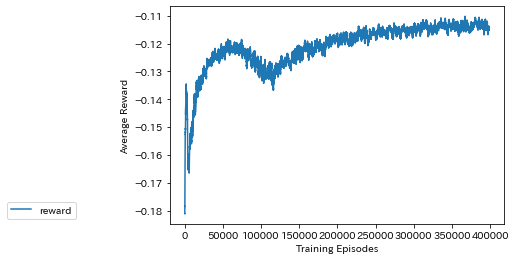

MODEL_PATH channel02_weight000_seed00/Qnet020000.pth
2 channel weight: =  0.05
RESULT_PATH channel02_weight005_seed00


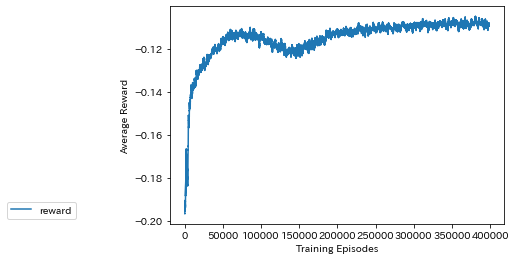

MODEL_PATH channel02_weight005_seed00/Qnet020000.pth


In [6]:
# 実験条件を指定
ACTIONS = ACTIONS_GR
SEED = 0
#TR_C = 3
TST_C = 3
for setting_num in [3, 4]:
    setting = getattr(settings, f'setting{setting_num}')
    CHANNEL = setting.CHANNEL
    WEIGHT = setting.WEIGHT
    print(CHANNEL, 'channel', 'weight: = ', WEIGHT)
    RESULT_PATH = os.path.join(
        'channel%02d_weight%03d_seed%02d' % (CHANNEL, int(100*WEIGHT), SEED)
    )
    print("RESULT_PATH", RESULT_PATH)

    # see reward
    ax = plt.subplot(111)
    ma = show_reward(ax, dir_path=RESULT_PATH, mono=False, n=1000, label='reward')
    plt.show()

In [10]:
# 3種類のフィルタ
labels = ['gauss', 'random', 'smooth']
for l in range(3):
    # 回数を1~5
    c = 3
    # データの読み込み
    context = np.load(
        os.path.join('data/GR/test', labels[l], f'c{c}_dataset.npz')
    )
    Dy = torch.from_numpy(context['test_dataset'])
    Dx = torch.from_numpy(context['original_dataset'])
    # MSEの算出
    result = agent_metrics(Dy, Dx, Qnet, actions, channel=channel)
    print(f'mse = {result[:, -1].mean():.3f}+-{result[:, -1].std():.4f}')
    # 結果の保存
    os.makedirs(os.path.join(RESULT_PATH, labels[l]), exist_ok=True)
    np.save(os.path.join('results', labels[l], f'c{c}_metric.npy'), result)

  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.019+-0.0066


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.022+-0.0083


100%|██████████| 10000/10000 [01:02<00:00, 161.25it/s]

mse = 0.024+-0.0094


復元結果の理想的なMSEを

In [8]:
len(filt)

5

In [7]:
for c in range(1, 6):
    print(list(product(range(3, 5), repeat=c)))
    print()

[(3,), (4,)]

[(3, 3), (3, 4), (4, 3), (4, 4)]

[(3, 3, 3), (3, 3, 4), (3, 4, 3), (3, 4, 4), (4, 3, 3), (4, 3, 4), (4, 4, 3), (4, 4, 4)]

[(3, 3, 3, 3), (3, 3, 3, 4), (3, 3, 4, 3), (3, 3, 4, 4), (3, 4, 3, 3), (3, 4, 3, 4), (3, 4, 4, 3), (3, 4, 4, 4), (4, 3, 3, 3), (4, 3, 3, 4), (4, 3, 4, 3), (4, 3, 4, 4), (4, 4, 3, 3), (4, 4, 3, 4), (4, 4, 4, 3), (4, 4, 4, 4)]

[(3, 3, 3, 3, 3), (3, 3, 3, 3, 4), (3, 3, 3, 4, 3), (3, 3, 3, 4, 4), (3, 3, 4, 3, 3), (3, 3, 4, 3, 4), (3, 3, 4, 4, 3), (3, 3, 4, 4, 4), (3, 4, 3, 3, 3), (3, 4, 3, 3, 4), (3, 4, 3, 4, 3), (3, 4, 3, 4, 4), (3, 4, 4, 3, 3), (3, 4, 4, 3, 4), (3, 4, 4, 4, 3), (3, 4, 4, 4, 4), (4, 3, 3, 3, 3), (4, 3, 3, 3, 4), (4, 3, 3, 4, 3), (4, 3, 3, 4, 4), (4, 3, 4, 3, 3), (4, 3, 4, 3, 4), (4, 3, 4, 4, 3), (4, 3, 4, 4, 4), (4, 4, 3, 3, 3), (4, 4, 3, 3, 4), (4, 4, 3, 4, 3), (4, 4, 3, 4, 4), (4, 4, 4, 3, 3), (4, 4, 4, 3, 4), (4, 4, 4, 4, 3), (4, 4, 4, 4, 4)]



In [16]:
# kernel4のテストデータの確認
c = 3
train_context = np.load(f'data/GR3.0/test/gauss/c{c}_dataset.npz')
Dy = train_context['test_dataset']
Dx = train_context['original_dataset']


def optimal_restore(yn, xn, actions):
    min_mse = 100
    min_funcs = None
    for c in range(1, 6):
        for funcs_idx in product(range(3, 5), repeat=c):
            yn_ = yn.copy()
            for func_idx in funcs_idx:
                yn_ = actions[func_idx](yn_)
            mse = np.mean((yn_ - xn)**2)
            if mse < min_mse:
                min_mse = mse
                min_funcs = funcs_idx
    m = 5 - len(min_funcs)
    min_funcs = list(min_funcs) + [0] * m
    return min_mse, min_funcs
    
init_mse = []
min_mses = []
min_funcses = []
for n in tqdm(range(Dy.shape[0])):
    yn = Dy[n].copy()
    xn = Dx[n]
    init_mse.append(np.mean((yn - xn)**2))
    
    min_mse, min_funcs = optimal_restore(yn, xn, filt)
    min_mses.append(min_mse)
    min_funcses.append(min_funcs)
    
init_mse = np.array(init_mse)
min_mses = np.array(min_mses)
min_funcses = np.array(min_funcses)

print('c =', c)
print('init', init_mse.mean())

print('min mse', min_mses.mean())


c = 3
init 0.041754009905595794
min mse 0.011243501826703


In [13]:
# kernel4のテストデータの確認
c = 3
train_context = np.load(f'data/GR3.0/test/gauss/c{c}_dataset.npz')
Dy = train_context['test_dataset']
Dx = train_context['original_dataset']
    
init_mse = []
mses = []
for n in tqdm(range(Dy.shape[0])):
    yn = Dy[n].copy()
    xn = Dx[n]
    init_mse.append(np.mean((yn - xn)**2))
    
    yn = yn.copy()
    for c in range(3):
        yn = filt[3](yn)
    mses.append(
        np.mean((yn - xn)**2)
    )
    
init_mse = np.array(init_mse)
mses = np.array(mses)

print('c =', c)
print('init', init_mse.mean())

print('gauss mses', mses.mean())


c = 2
init 0.041754009905595794
min mse 0.01403988877732478


gauss
0.023(0.0053)	0.034(0.0077)	0.042(0.0096)	0.047(0.0110)	0.051(0.0122)	
0.043(0.0384)	0.039(0.0232)	0.041(0.0167)	0.046(0.0156)	0.052(0.0167)	
0.016(0.0088)	0.014(0.0074)	0.015(0.0063)	0.022(0.0084)	0.041(0.0175)	
0.012(0.0055)	0.012(0.0045)	0.014(0.0050)	0.022(0.0077)	0.042(0.0180)	

random
0.029(0.0071)	0.038(0.0090)	0.046(0.0110)	0.051(0.0124)	0.055(0.0135)	
0.040(0.0314)	0.039(0.0177)	0.045(0.0156)	0.052(0.0173)	0.057(0.0206)	
0.017(0.0103)	0.015(0.0068)	0.022(0.0093)	0.043(0.0196)	0.059(0.0253)	
0.013(0.0054)	0.015(0.0051)	0.021(0.0082)	0.044(0.0206)	0.063(0.0253)	

smooth
0.030(0.0070)	0.040(0.0091)	0.047(0.0111)	0.052(0.0125)	0.056(0.0136)	
0.039(0.0286)	0.040(0.0166)	0.046(0.0153)	0.054(0.0177)	0.059(0.0211)	
0.017(0.0097)	0.015(0.0061)	0.025(0.0100)	0.049(0.0206)	0.062(0.0260)	
0.013(0.0050)	0.015(0.0051)	0.024(0.0094)	0.051(0.0212)	0.065(0.0238)	




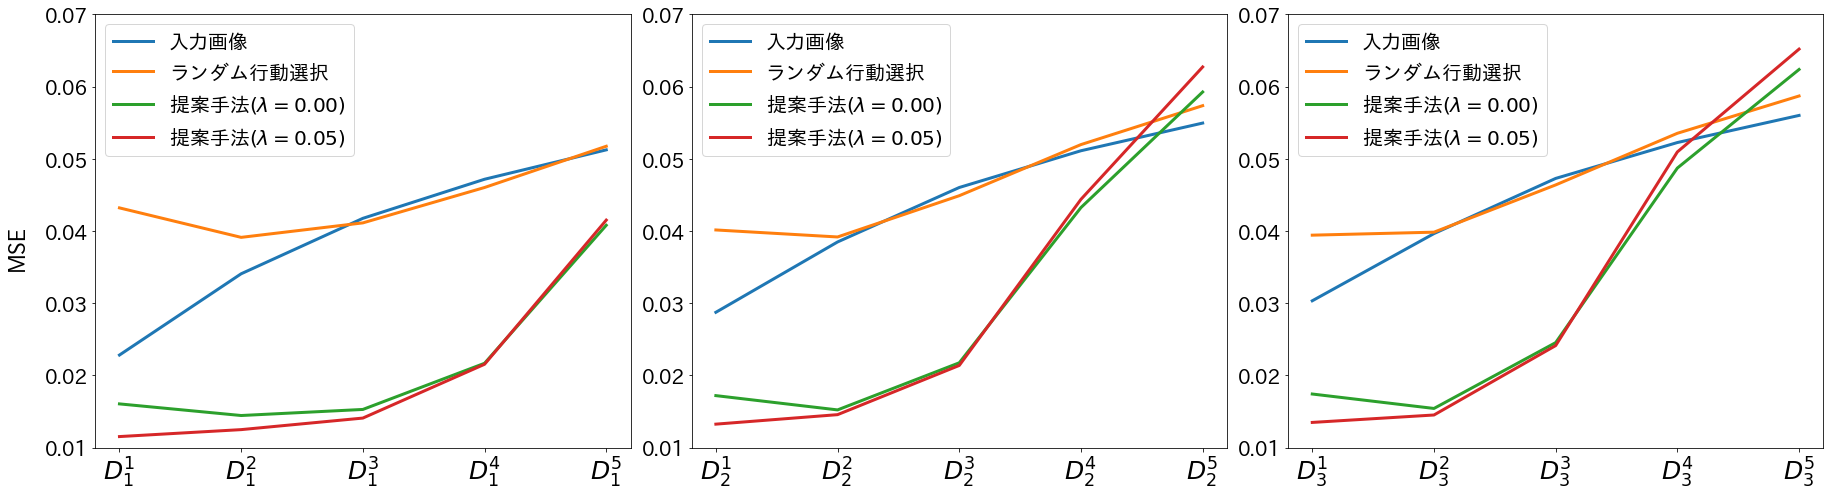

In [54]:
# 測定したMSEの可視化
base = ''
template_init_random = 'init_random/{label}_c{c}_metric.npy'
template_model = 'channel{channel:02d}_weight{weight:03d}_seed00/{label}/c{c}_metrics.npy'
labels = ['gauss', 'random', 'smooth']
t = 0
# 結果を表で保存
# 1次元目は、どのフィルタを用いてテストデータを作成したか
# [入力画像, ランダム, 提案手法(lambda = 0.00), 提案手法(lambda = 0.05)]で
# データセット
table = np.zeros((3, 4, 10))
for l in range(len(labels)):
    label = labels[l]
    for c in range(1, 6):
        mse_index = 2*(c-1)
        std_index = 2*(c-1) + 1
        init_random = np.load(os.path.join(base, template_init_random.format(label=label, c=c)))
        init_mse = init_random[:, 0]
        table[l, 0, mse_index] = init_mse.mean()
        table[l, 0, std_index] = init_mse.std()
        random_mse = init_random[:, 1]
        table[l, 1, mse_index] = random_mse.mean()
        table[l, 1, std_index] = random_mse.std()
        model1_mse = np.load(
            os.path.join(base, template_model.format(channel=2, weight=0, label=label, c=c))
        )[:, -1]
        table[l, 2, mse_index] = model1_mse.mean()
        table[l, 2, std_index] = model1_mse.std()
        model2_mse = np.load(
            os.path.join(base, template_model.format(channel=2, weight=5, label=label, c=c))
        )[:, -1]
        table[l, 3, mse_index] = model2_mse.mean()
        table[l, 3, std_index] = model2_mse.std()
np.save(os.path.join(base, 'metrics_table.npy'), table)

for l in range(3):
    print(labels[l])
    for m in range(4):
        for c in range(5):
            print(f'{table[l, m, 2*c]:.3f}({table[l, m, 2*c+1]:.4f})', end='\t')
        print()
    print()

tick_labels = [
    ['$D_1^1$', '$D_1^2$', '$D_1^3$', '$D_1^4$', '$D_1^5$'],
    ['$D_2^1$', '$D_2^2$', '$D_2^3$', '$D_2^4$', '$D_2^5$'],
    ['$D_3^1$', '$D_3^2$', '$D_3^3$', '$D_3^4$', '$D_3^5$'],
]

labels = ['入力画像', 'ランダム行動選択', '提案手法$(\lambda = 0.00)$', '提案手法$(\lambda = 0.05)$']
fig, axes = plt.subplots(1, 3, figsize=(25, 7))
print()
for l in range(3):
    axes[l].set_xticks(range(5))
    axes[l].set_ylim(0.01, 0.07)
    axes[l].tick_params(labelsize=20)
    axes[l].set_xticklabels(tick_labels[l], fontsize=25)
    
    for m in range(4):
        d = table[l, m, np.arange(0, 10, 2)]  #FIXME
        axes[l].plot(d, label=labels[m], lw=3)
    axes[l].legend(loc='upper left', fontsize=20)
fig.text(-0.015, 0.5, 'MSE', va='center', rotation='vertical', fontsize=22)
plt.tight_layout()

In [41]:
# 原先生の手元で学習したAgentが選択する行動を可視化する。
# 論文に反映するための画像
channel = 2
Qnet = QNet(c=channel, m=[20, 20, len(filt)])
Qnet.load_state_dict(torch.load('./Qnet020000.pth', map_location=torch.device('cpu')))
Qnet = Qnet.to(torch.float)

result_gauss = np.load(f'results/gauss/c3_metric.npy')[:, :-1]
result_random = np.load(f'results/random/c3_metric.npy')[:, :-1]
result_smooth = np.load(f'results/smooth/c3_metric.npy')[:, :-1]

a = result_gauss
b = result_random
c = result_smooth
mask = (a[:, 0] == b[:, 0]) & (b[:, 0] == c[:, 0])
for j in range(1, 3):
    mask = mask & ((a[:, j] == b[:, j]) & (b[:, j] == c[:, j]))
mask = ~mask
mask = mask &(b[:, 0] == 4) & (b[:, 1] == 4)

Dx = np.load('data/GR3.0/test/gauss/c3_dataset.npz')['original_dataset']
Dy_gauss = np.load('data/GR3.0/test/gauss/c3_dataset.npz')['test_dataset']
Dy_random = np.load('data/GR3.0/test/random/c3_dataset.npz')['test_dataset']
Dy_smooth = np.load('data/GR3.0/test/smooth/c3_dataset.npz')['test_dataset']


agent = Agent(Qnet, filt, 2)
action_labels = ['$a_0$', '$a_1$', '$a_2$', '$a_3$', '$a_4$']
def show_restore(agent, yn, xn, label):
    fs = 40
    yn = torch.from_numpy(yn.copy()).to(torch.float)
    _, aN = agent(yn)
    yn = yn.cpu().numpy()
    print(label)
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 6, 1)
    plt.title('$y$', fontsize=fs)
    plt.axis('off')
    plt.imshow(yn)
    for i, a in enumerate(aN, start=2):
        yn = filt[a](yn)
        plt.subplot(1, 6, i)
        plt.title('\Huge{%s}\small(%.3lf)' % (action_labels[a], np.mean((yn - xn)**2)), fontsize=fs)
        plt.gca().title.set_position([0.5, 2])
        plt.imshow(yn)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    
for n in np.arange(Dy.shape[0])[mask][:10]:
    xn = Dx[n]
    yn_gauss = Dy_gauss[n]
    show_restore(agent, yn_gauss, xn, 'gauss')
    
    yn_random = Dy_random[n]
    show_restore(agent, yn_random, xn, 'random')
    
    yn_smooth = Dy_smooth[n]
    show_restore(agent, yn_smooth, xn, 'smooth')
    print()

gauss


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1296x432 with 6 Axes>

In [5]:
labels = ['gauss', 'random', 'smooth']
actions = filt
# 結果の対象パスどこ
# setting3, setting4
seed = 0
RESULT_PATH = 'results/GR3.0/'
# 3種類のフィルタ
for l in range(3):
    # 回数を1~5
    for c in range(1, 6):
        # データの読み込み
        context = np.load(
            os.path.join('data/GR3.0/test', labels[l], f'c{c}_dataset.npz')
        )
        Dy = context['test_dataset']
        Dx = context['original_dataset']
        print(Dy.shape[0])
        # 入力画像のMSE
        init_mse = np.mean((Dy - Dx)**2, axis=(1, 2))
        # ランダムに行動を選択した場合のMSE
        random_mse = []
        # random actions
        np.random.seed(seed + 100)
        aN = np.random.choice(len(actions), (Dy.shape[0], 5))
        for n in range(Dy.shape[0]):
            xn = Dx[n]
            yn = Dy[n].copy()
            an = aN[n]
            # ステップ数
            for a in an:
                yn = actions[a](yn)
            random_mse.append(
                np.mean((yn - xn)**2)
            )
        random_mse = np.array(random_mse)
        # 結果の保存
        os.makedirs(os.path.join(RESULT_PATH, 'init_random'), exist_ok=True)
        result = np.c_[init_mse, random_mse]
        print()
        print('init', init_mse.mean(), init_mse.std())
#         print('init', result[:, 0].mean(), result[:, 0].std())
#         print('random', result[:, 1].mean(), result[:, 1].std())
        print('random', random_mse.mean(), random_mse.std())
        np.save(os.path.join(RESULT_PATH, 'init_random', f'{labels[l]}_c{c}_metric.npy'), result)

10000

init 0.02281997649605797 0.005335388064689591
random 0.04320162746721808 0.0383614748250176
10000

init 0.03407595348683115 0.0077289300149506815
random 0.03911889581007544 0.0232095852477037
10000

init 0.041754009905595794 0.009587872085103213
random 0.041123992102042414 0.016733005157157307
10000

init 0.04716768946965732 0.011038493897916595
random 0.04602531518909829 0.015591974711013912
10000

init 0.05123841222416039 0.012202082100247692
random 0.051736697883879836 0.01674724017303586
10000

init 0.028740643939728926 0.007090986113147228
random 0.0401451317794673 0.03140658432374556
10000

init 0.03848262540650478 0.009021567951811384
random 0.03917343539772057 0.017711796519625265
10000

init 0.04602599343577285 0.01097100514796247
random 0.0448888375293425 0.01563626099739951
10000

init 0.05111559965701586 0.012379509899865332
random 0.051968320616416895 0.01733629913168028
10000

init 0.054948094564742096 0.013501489993416563
random 0.05735810270866755 0.0206127435046

In [12]:
# Qnetでの性能を測定
labels = ['gauss', 'random', 'smooth']
actions = [lambda x: x] + ACTIONS_GR
# setting3, setting4
seed = 0
# for setting_num in [3, 4]:
for setting_num in [4]:
    setting = getattr(settings, f'setting{setting_num}')
    channel = setting.CHANNEL
    weight = setting.WEIGHT
    RESULT_PATH = os.path.join(
        'channel%02d_weight%03d_seed%02d' % (channel, int(100*weight), seed)
    )
    Qnet = QNet(c=channel, m=[20, 20, len(actions)])
#     MODEL_PATH = os.path.join(RESULT_PATH, 'Qnet020000.pth')
    MODEL_PATH = os.path.join(RESULT_PATH, 'Qnet020000.pth')
    print('MODEL_PATH', MODEL_PATH)
    Qnet.load_state_dict(
        torch.load(MODEL_PATH)
    )
    # 3種類のフィルタ
    for l in range(3):
        # 回数を1~5
        for c in range(1, 6):
            # データの読み込み
            context = np.load(
                os.path.join('data/GR/test', labels[l], f'c{c}_dataset.npz')
            )
            Dy = torch.from_numpy(context['test_dataset'])
            Dx = torch.from_numpy(context['original_dataset'])
            # MSEの算出
            result = agent_metrics(Dy, Dx, Qnet, actions, channel=channel)
            print(f'mse = {result[:, -1].mean():.3f}+-{result[:, -1].std():.4f}')
            # 結果の保存
            os.makedirs(os.path.join(RESULT_PATH, labels[l]), exist_ok=True)
            np.save(os.path.join(RESULT_PATH, labels[l], f'c{c}_metric.npy'), result)

  0%|          | 0/10000 [00:00<?, ?it/s]

MODEL_PATH channel02_weight005_seed00/Qnet020000.pth


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.014+-0.0064


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.015+-0.0053


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.019+-0.0067


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.043+-0.0207


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.064+-0.0268


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.014+-0.0067


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.016+-0.0059


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.021+-0.0091


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.048+-0.0240


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.066+-0.0288


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.015+-0.0062


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.017+-0.0053


100%|██████████| 10000/10000 [01:11<00:00, 139.70it/s]


mse = 0.025+-0.0102


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.054+-0.0241


100%|██████████| 10000/10000 [01:25<00:00, 116.89it/s]

mse = 0.069+-0.0278


gauss
0.023(0.0053)	0.034(0.0077)	0.042(0.0096)	0.047(0.0110)	0.051(0.0122)	
0.049(0.0469)	0.043(0.0298)	0.043(0.0191)	0.047(0.0169)	0.053(0.0201)	
0.019(0.0113)	0.017(0.0075)	0.020(0.0081)	0.042(0.0197)	0.056(0.0235)	
0.014(0.0064)	0.015(0.0053)	0.019(0.0067)	0.043(0.0207)	0.064(0.0268)	

random
0.029(0.0071)	0.038(0.0090)	0.046(0.0110)	0.051(0.0124)	0.055(0.0135)	
0.045(0.0398)	0.041(0.0215)	0.046(0.0169)	0.053(0.0209)	0.059(0.0257)	
0.019(0.0117)	0.017(0.0079)	0.023(0.0113)	0.045(0.0218)	0.058(0.0253)	
0.014(0.0067)	0.016(0.0059)	0.021(0.0091)	0.048(0.0240)	0.066(0.0288)	

smooth
0.030(0.0070)	0.040(0.0091)	0.047(0.0111)	0.052(0.0125)	0.056(0.0136)	
0.044(0.0364)	0.041(0.0190)	0.047(0.0167)	0.055(0.0218)	0.061(0.0266)	
0.019(0.0108)	0.017(0.0073)	0.026(0.0114)	0.050(0.0224)	0.060(0.0238)	
0.015(0.0062)	0.017(0.0053)	0.025(0.0102)	0.054(0.0241)	0.069(0.0278)	




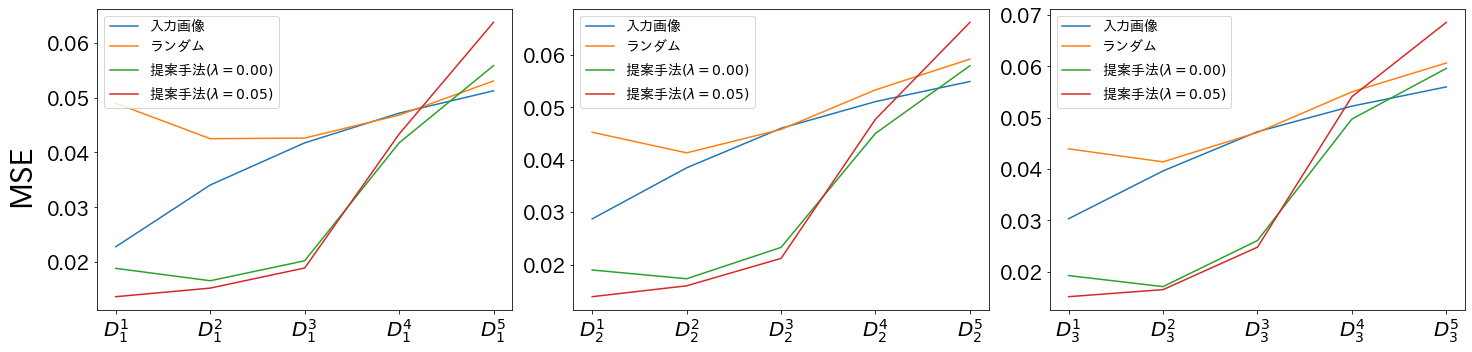

In [4]:
# 測定したMSEの可視化
base = ''
template_init_random = 'results/GR3.0/init_random/{label}_c{c}_metric.npy'
template_model = 'channel{channel:02d}_weight{weight:03d}_seed00/{label}/c{c}_metric.npy'
labels = ['gauss', 'random', 'smooth']
t = 0
# 結果を表で保存
# 1次元目は、どのフィルタを用いてテストデータを作成したか
# [入力画像, ランダム, 提案手法(lambda = 0.00), 提案手法(lambda = 0.05)]で
# データセット
table = np.zeros((3, 4, 10))
for l in range(len(labels)):
    label = labels[l]
    for c in range(1, 6):
        mse_index = 2*(c-1)
        std_index = 2*(c-1) + 1
        init_random = np.load(os.path.join(base, template_init_random.format(label=label, c=c)))
        init_mse = init_random[:, 0]
        table[l, 0, mse_index] = init_mse.mean()
        table[l, 0, std_index] = init_mse.std()
        random_mse = init_random[:, 1]
        table[l, 1, mse_index] = random_mse.mean()
        table[l, 1, std_index] = random_mse.std()
        model1_mse = np.load(
            os.path.join(base, template_model.format(channel=2, weight=0, label=label, c=c))
        )[:, -1]
        table[l, 2, mse_index] = model1_mse.mean()
        table[l, 2, std_index] = model1_mse.std()
        model2_mse = np.load(
            os.path.join(base, template_model.format(channel=2, weight=5, label=label, c=c))
        )[:, -1]
        table[l, 3, mse_index] = model2_mse.mean()
        table[l, 3, std_index] = model2_mse.std()
np.save(os.path.join(base, 'metrics_table.npy'), table)

for l in range(3):
    print(labels[l])
    for m in range(4):
        for c in range(5):
            print(f'{table[l, m, 2*c]:.3f}({table[l, m, 2*c+1]:.4f})', end='\t')
        print()
    print()

tick_labels = [
    ['$D_1^1$', '$D_1^2$', '$D_1^3$', '$D_1^4$', '$D_1^5$'],
    ['$D_2^1$', '$D_2^2$', '$D_2^3$', '$D_2^4$', '$D_2^5$'],
    ['$D_3^1$', '$D_3^2$', '$D_3^3$', '$D_3^4$', '$D_3^5$'],
]

labels = ['入力画像', 'ランダム', '提案手法$(\lambda = 0.00)$', '提案手法$(\lambda = 0.05)$']
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
print()
for l in range(3):
    axes[l].set_xticks(range(5))
    axes[l].set_xticklabels(tick_labels[l])
    axes[l].tick_params(labelsize=20)
    for m in range(4):
        d = table[l, m, np.arange(0, 10, 2)]  #FIXME
        axes[l].plot(d, label=labels[m])
    axes[l].legend(loc='upper left', fontsize=14)
fig.text(-0.02, 0.5, 'MSE', va='center', rotation='vertical', fontsize=30)
plt.tight_layout()

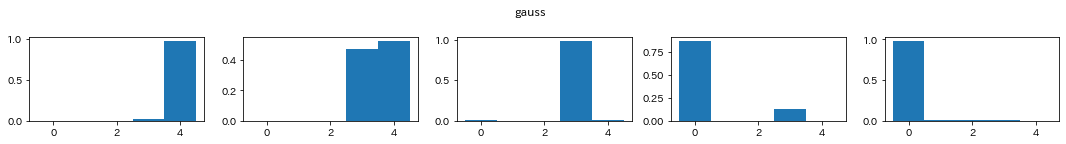

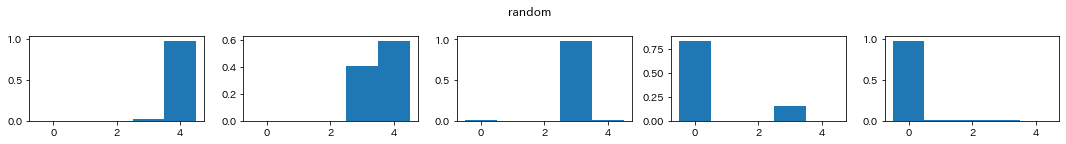

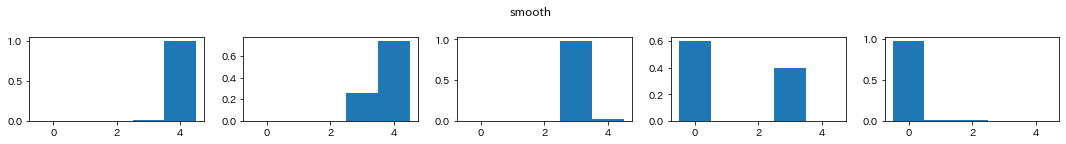

In [5]:
for label in ['gauss', 'random', 'smooth']:
    result_gauss = np.load(f'channel02_weight005_seed00/{label}/c3_metric.npy')
    fig, axes = plt.subplots(1, 5, figsize=(15, 2))
    fig.suptitle(label)
    for j in range(5):
        axes[j].hist(result_gauss[:, j], bins=np.arange(6) - 0.5, density=True)
    plt.tight_layout()
    plt.show()